In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('Downloads/events_log.csv.gz',  compression='gzip',
                   error_bad_lines=False)

In [3]:
data.head()

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position
0,00000736167c507e8ec225bd9e71f9e5,2.016030e+13,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN
1,00000c69fe345268935463abbfa5d5b3,2.016031e+13,c559c3be98dca8a4,a,searchResultPage,NaN,eb658e8722aad674,10.0,NaN
2,00003bfdab715ee59077a3670331b787,2.016030e+13,760bf89817ce4b08,a,checkin,30.0,f99a9fc1f7fdd21e,NaN,NaN
3,0000465cd7c35ad2bdeafec953e08c1a,2.016030e+13,fb905603d31b2071,a,checkin,60.0,e5626962a6939a75,NaN,10.0
4,000050cbb4ef5b42b16c4d2cf69e6358,2.016030e+13,c2bf5e5172a892dc,a,checkin,30.0,787dd6a4c371cbf9,NaN,NaN


In [4]:
data.dtypes

uuid                object
timestamp          float64
session_id          object
group               object
action              object
checkin            float64
page_id             object
n_results          float64
result_position    float64
dtype: object

In [5]:
import datetime as dt
data['timestamp'] = pd.to_datetime(data['timestamp'].astype(str).str[:14],format='%Y%m%d%H%M%S')

In [6]:
pd.isnull(data).sum()

uuid                    0
timestamp               0
session_id              0
group                   0
action                  0
checkin            176341
page_id                 0
n_results          263931
result_position    169683
dtype: int64

In [7]:
## Page opened most for 10 seconds
data['day'] = data['timestamp'].dt.weekday_name

In [8]:
data['group'].value_counts()

a    299019
b    101146
Name: group, dtype: int64

In [10]:
#data['n_results'].value_counts()


In [12]:
data['action'].value_counts()

checkin             223824
searchResultPage    136234
visitPage            40107
Name: action, dtype: int64

In [100]:
data[data['action'] == 'checkin']['checkin'].head()

2     30.0
3     60.0
4     30.0
5    180.0
6    240.0
Name: checkin, dtype: float64

In [101]:
#data[data['action'] == 'searchResultPage']['n_results'].sort_values()

In [102]:
## to see if the column n_result has all values corresponding to 'searchResultPage'
all(data[data['n_results'].notnull()]['action'] == 'searchResultPage')

False

In [103]:
## to see if the column checkin has all values corresponding to 'checkin' category 
all(data[data['checkin'].notnull()]['action'] == 'checkin')

True

In [104]:
## to see if the column result_position has all values corresponding to 'checkin'
## four values corresponds to visitpage
all(data[data['result_position'].notnull()]['action'] == 'checkin')

False

In [105]:
data['date'] = data['timestamp'].dt.date

In [106]:
data['action'].value_counts()

checkin      223824
1            111107
visitPage     40107
0             25127
Name: action, dtype: int64

## 1. What is their daily overall click through rate? How does it vary between the groups?

In [107]:
session_summary = data[data['n_results'] != 0].groupby(['date','group', 'session_id', 'action']).size().unstack()
session_summary.head()

action                               1  checkin  visitPage
date       group session_id                               
2016-03-01 a     001a3950cd4ac6c6  1.0      NaN        NaN
                 0024c4506bf92e1c  2.0     23.0        2.0
                 0024f4f005f34c9d  3.0      NaN        NaN
                 0029420a5f8c7d90  3.0      NaN        1.0
                 002b97995ca9ce77  3.0      2.0        2.0

In [108]:
is_click_session = pd.DataFrame(session_summary['visitPage'].map(lambda x : 1 if x >= 1 else 0)).reset_index()
is_click_session.head()

,date,group,session_id,visitPage
0,2016-03-01,a,001a3950cd4ac6c6,0
1,2016-03-01,a,0024c4506bf92e1c,1
2,2016-03-01,a,0024f4f005f34c9d,0
3,2016-03-01,a,0029420a5f8c7d90,1
4,2016-03-01,a,002b97995ca9ce77,1


In [109]:
is_click_session.groupby('date')['visitPage'].mean()


date
2016-03-01    0.431018
2016-03-02    0.441097
2016-03-03    0.436237
2016-03-04    0.447089
2016-03-05    0.437957
2016-03-06    0.443382
2016-03-07    0.442960
2016-03-08    0.440454
Name: visitPage, dtype: float64

In [111]:
is_click_session.groupby(['date', 'group'])['visitPage'].mean().unstack()

group,a,b
date,,
2016-03-01,0.708731,0.166826
2016-03-02,0.714783,0.175078
2016-03-03,0.707287,0.182242
2016-03-04,0.706968,0.228593
2016-03-05,0.681344,0.246196
2016-03-06,0.710827,0.229570
2016-03-07,0.691564,0.237365
2016-03-08,0.699569,0.223111


## 2.Which result position do people tend to try first? How does it change day-to-day?

In [112]:
min_session = data[data.action == 'visitPage'].groupby(['date', 'session_id'])['timestamp'].min().reset_index()

In [113]:
min_session['random'] = 1

In [114]:
df2 = pd.merge(data[data.action == 'visitPage'], min_session, left_on = ['date', 'session_id', 'timestamp'], right_on = ['date', 'session_id', 'timestamp'], how='left', suffixes=['_1','_2'])

In [115]:
df2[df2.random == 1].groupby(['date', 'result_position']).size().reset_index().groupby('date').first()

,result_position,0
date,,
2016-03-01,1.0,2384
2016-03-02,1.0,2396
2016-03-03,1.0,2422
2016-03-04,1.0,2240
2016-03-05,1.0,1705
2016-03-06,1.0,1978
2016-03-07,1.0,2474
2016-03-08,1.0,2114


## 3. What is their daily overall zero results rate? How does it vary between the groups?

In [116]:
d = data[data['n_results'] == 0]
zero_result = pd.DataFrame(d.groupby(['date', 'session_id'])['n_results'].size().reset_index()).rename(columns = {'n_results' : 'zero_results'})
all_result = pd.DataFrame(data.groupby(['date', 'session_id'])['n_results'].size().reset_index()).rename(columns = {'n_results' : 'all_results'})

In [117]:
result = pd.merge(zero_result, all_result, on=['date', 'session_id'])

In [118]:
result['zero_result_rate'] = result['zero_results']/result['all_results']*100
result.head()

,date,session_id,zero_results,all_results,zero_result_rate
0,2016-03-01,001a3950cd4ac6c6,4,5,80.0
1,2016-03-01,00429c6a475ab250,1,1,100.0
2,2016-03-01,00528f41689a87eb,2,2,100.0
3,2016-03-01,005522d0fb5a2b0a,1,5,20.0
4,2016-03-01,005febb3441161da,1,1,100.0


In [119]:
d = data[data['n_results'] == 0]
zero_result = pd.DataFrame(d.groupby(['date', 'session_id', 'group'])['n_results'].size().reset_index()).rename(columns = {'n_results' : 'zero_results'})
all_result = pd.DataFrame(data.groupby(['date', 'session_id', 'group'])['n_results'].size().reset_index()).rename(columns = {'n_results' : 'all_results'})

In [120]:
result = pd.merge(zero_result, all_result, on=['date', 'session_id', 'group'])

In [121]:
result['zero_result_rate'] = result['zero_results']/result['all_results']*100
result.groupby(['group'])['zero_result_rate'].mean()

group
a    45.350762
b    92.933896
Name: zero_result_rate, dtype: float64

## 4.	Let session length be approximately the time between the first event and the last event in a session. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship.

In [122]:
max_dt = pd.DataFrame(data.groupby(['date', 'session_id'])['timestamp'].max()).rename(columns = {'timestamp' : 'max_dt'})
min_dt = pd.DataFrame(data.groupby(['date', 'session_id'])['timestamp'].min()).rename(columns = {'timestamp' : 'min_dt'})

In [123]:
checkin = pd.DataFrame(data.groupby(['date', 'session_id'])['checkin'].sum())
session_df = pd.concat([max_dt, min_dt, checkin], axis=1, sort=False)

In [124]:
from datetime import timedelta
session_df['session_length'] = session_df['max_dt'] - session_df['min_dt']

In [126]:
session_df.head()


max_dt              min_dt  checkin  \
date       session_id                                                          
2016-03-01 000936ae06d62383 2016-03-01 12:36:54 2016-03-01 12:36:54      0.0   
           001544bc03fac3e8 2016-03-01 11:36:18 2016-03-01 11:35:58      0.0   
           001a3950cd4ac6c6 2016-03-01 18:08:48 2016-03-01 18:08:06      0.0   
           001e2d0e159172d2 2016-03-01 00:43:35 2016-03-01 00:43:21     10.0   
           0022bba0634595b9 2016-03-01 03:37:39 2016-03-01 03:37:39      0.0   

                            session_length  
date       session_id                       
2016-03-01 000936ae06d62383       00:00:00  
           001544bc03fac3e8       00:00:20  
           001a3950cd4ac6c6       00:00:42  
           001e2d0e159172d2       00:00:14  
           0022bba0634595b9       00:00:00

Text(0.5,1,'Relationship between Session length vs Checkin duration ')

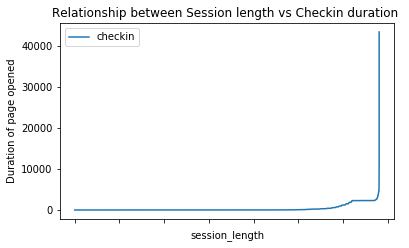

In [54]:
pt = session_df.sort_values('checkin').plot(x = 'session_length', y = 'checkin')
pt.set_xlabel("session_length")
pt.set_ylabel("Duration of page opened")
pt.set_title("Relationship between Session length vs Checkin duration ")

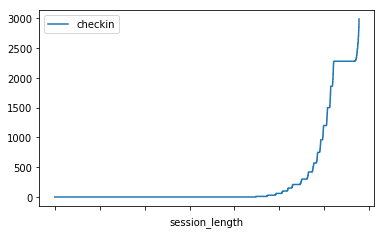

In [55]:
session_df[session_df['checkin'] < 3000].sort_values('checkin').plot(x = 'session_length', y = 'checkin')

In [68]:
import numpy as np
data['is_clicked'] = np.nan

In [85]:
data.head()

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,day,date,is_clicked
0,00000736167c507e8ec225bd9e71f9e5,2016-03-01 10:38:42,78245c2c3fba013a,b,1,NaN,cbeb66d1bc1f1bc2,5.0,NaN,Tuesday,2016-03-01,NaN
1,00000c69fe345268935463abbfa5d5b3,2016-03-07 00:52:26,c559c3be98dca8a4,a,1,NaN,eb658e8722aad674,10.0,NaN,Monday,2016-03-07,NaN
2,00003bfdab715ee59077a3670331b787,2016-03-02 14:53:05,760bf89817ce4b08,a,checkin,30.0,f99a9fc1f7fdd21e,NaN,NaN,Wednesday,2016-03-02,NaN
3,0000465cd7c35ad2bdeafec953e08c1a,2016-03-02 22:27:01,fb905603d31b2071,a,checkin,60.0,e5626962a6939a75,NaN,10.0,Wednesday,2016-03-02,NaN
4,000050cbb4ef5b42b16c4d2cf69e6358,2016-03-02 09:50:23,c2bf5e5172a892dc,a,checkin,30.0,787dd6a4c371cbf9,NaN,NaN,Wednesday,2016-03-02,NaN


In [94]:
data['is_clicked'].value_counts()

1.0    40107
Name: is_clicked, dtype: int64

In [86]:
data.loc[(data['action'] == 'visitPage'), 'is_clicked'] = 1